In [1]:
%matplotlib notebook
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, tof_calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools


In [2]:
number_sample = 300
save_fig=True
plot_fig=False 

In [3]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [4]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [5]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//load_crop')
variables.result_path = os.path.join(p, 'tests/results/tof_calibration/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'



head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)


In [6]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp
0,5216.226562,5216.226562,1572.0,633.384306,-0.031837,0.859592,0.0,1.0
1,5216.226562,5216.226562,1791.0,628.981470,-0.350204,-18.720000,219.0,1.0
2,5216.226562,5216.226562,1992.0,635.510286,-11.906939,2.610612,201.0,1.0
3,5216.226562,5216.226562,2429.0,624.222018,7.195102,-0.827755,437.0,1.0
4,5216.226562,5216.226562,3220.0,629.276364,14.644898,7.449796,791.0,1.0
...,...,...,...,...,...,...,...,...
1859758,5711.025879,5711.025879,3626.0,601.419168,-4.998367,-1.846531,152.0,1.0
1859759,5711.025879,5711.025879,3641.0,602.674182,-0.827755,-14.867755,15.0,1.0
1859760,5711.025879,5711.025879,4538.0,600.644214,-6.271837,3.565714,897.0,1.0
1859761,5711.025879,5711.025879,5881.0,459.993492,34.097143,5.380408,1343.0,1.0


In [7]:
# t0
dld_t = data['t (ns)'].to_numpy()
dld_t = dld_t - t0

In [8]:
# Remove negative and zero TOF
threshold = t0 + 20
dld_t_mask = data['t (ns)'].to_numpy()
dld_t_mask = (dld_t < threshold)
data.drop(np.where(dld_t_mask)[0], inplace=True)
data.reset_index(inplace=True, drop=True)

In [9]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x (mm)'].to_numpy()
dld_y = data['y (mm)'].to_numpy()

<IPython.core.display.Javascript object>


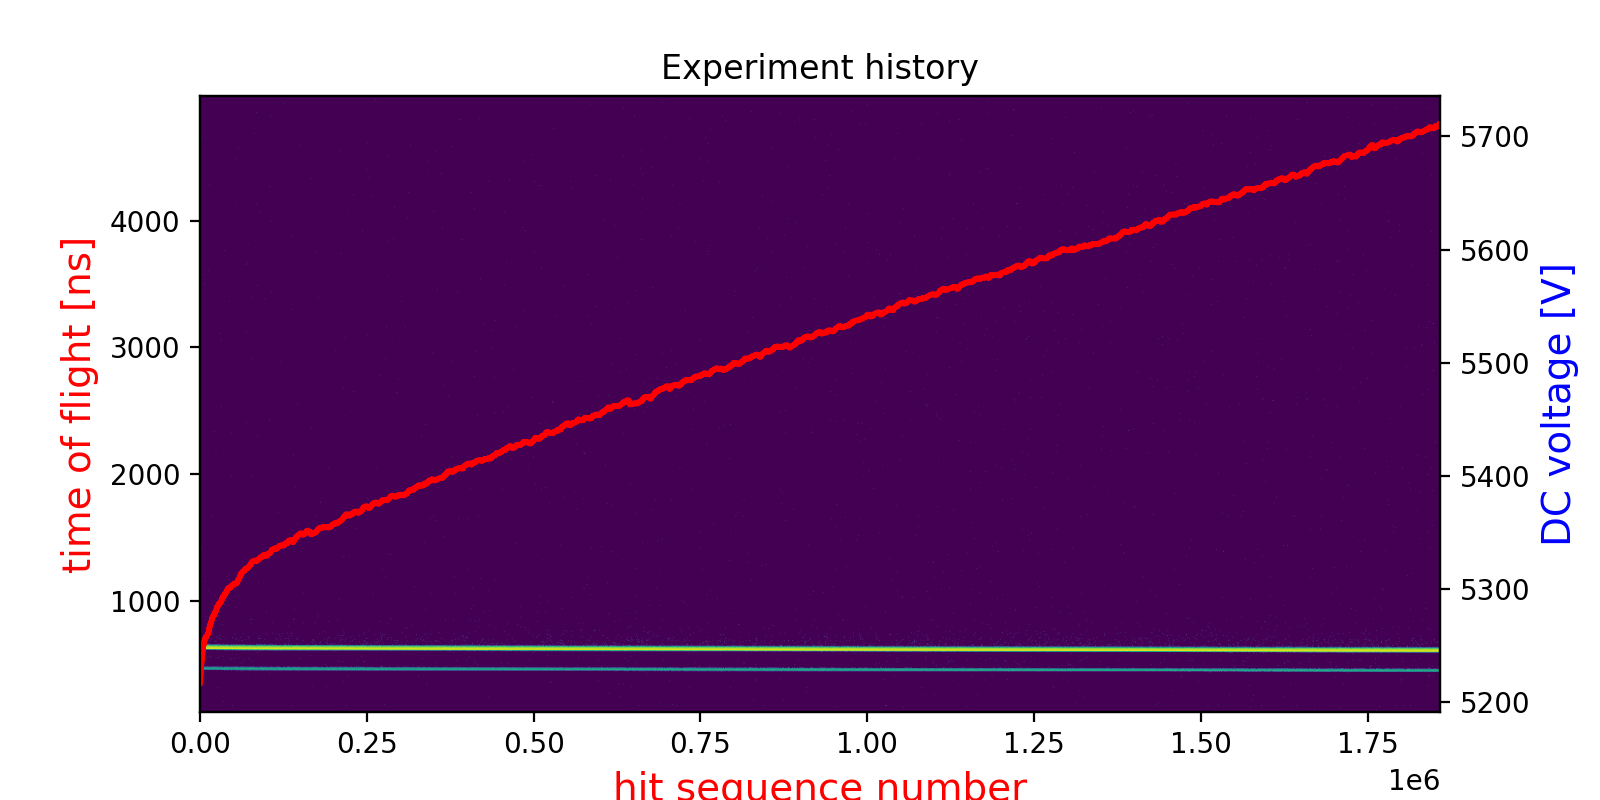

In [10]:
fig1, ax1 = plt.subplots(figsize=(8, 4))

yaxis = dld_t[dld_t < 5000]  # dld_t
# y[y>5000] = 0
xaxis = np.arange(len(yaxis))
heatmap, xedges, yedges = np.histogram2d(xaxis, yaxis, bins=(1200, 800))
heatmap[heatmap == 0] = 1  # to have zero after apply log
heatmap = np.log(heatmap)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
# set x-axis label
ax1.set_xlabel("hit sequence number", color="red", fontsize=14)
# set y-axis label
ax1.set_ylabel("time of flight [ns]", color="red", fontsize=14)
plt.title("Experiment history")
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect="auto")

# plot high voltage curve
ax2 = ax1.twinx()

# dldGroupStorage[0] --> dld/high_voltage
high_voltage = dld_highVoltage[dld_t < 5000]
xaxis = np.arange(len(high_voltage))
ax2.plot(xaxis, high_voltage, color='r', linewidth=2)
ax2.set_ylabel("DC voltage [V]", color="blue", fontsize=14)
plt.show()

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

10-24-2022 11:01:36 | INFO | Selected Mode = count
10-24-2022 11:01:36 | INFO | Selected Mode = count
10-24-2022 11:01:36 | INFO | Selected Mode = count
10-24-2022 11:01:36 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


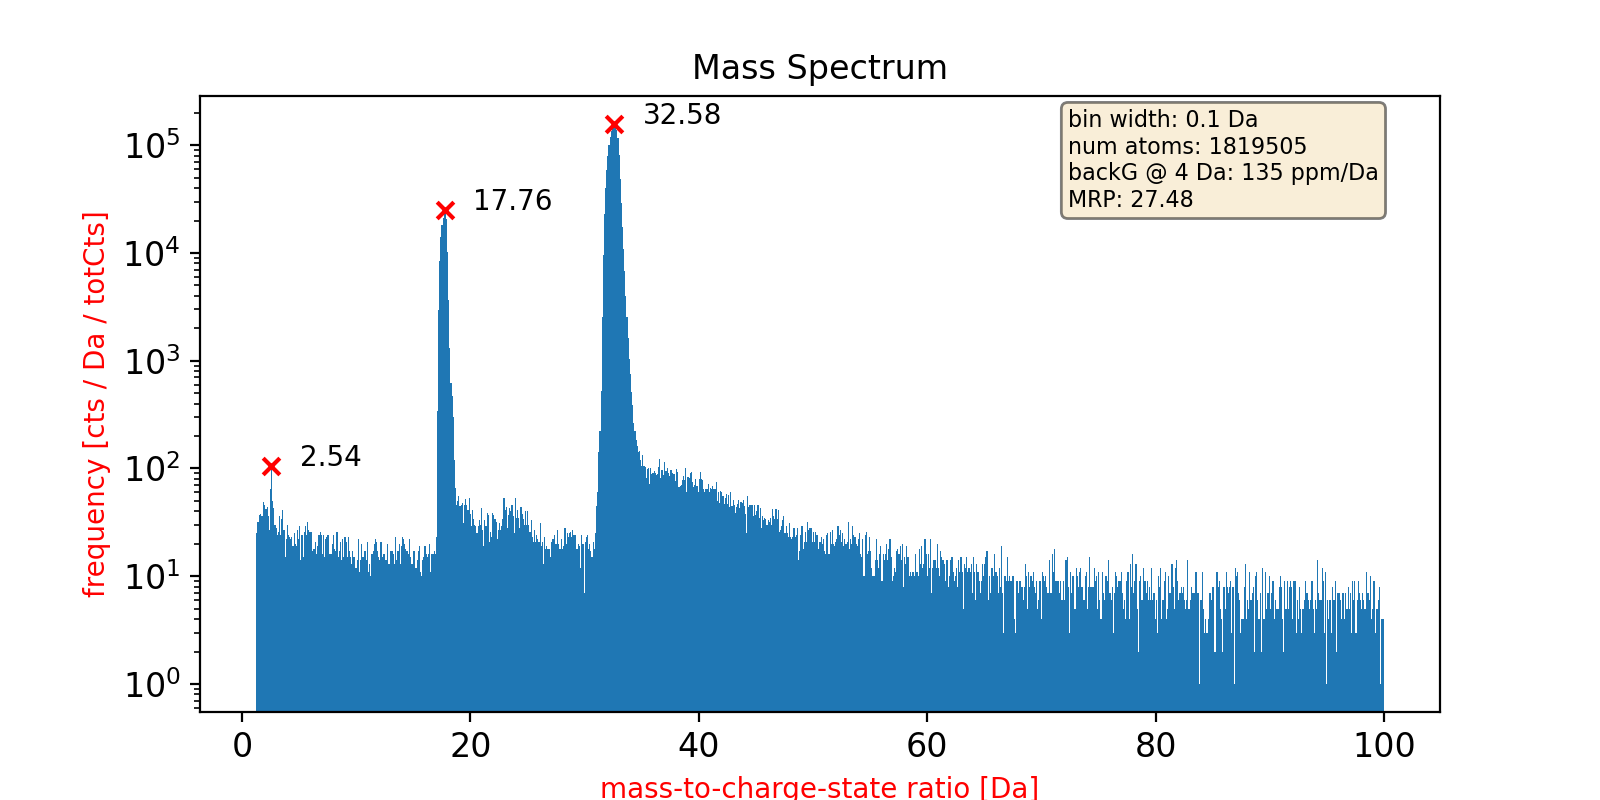

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [27.47702223]
Peaks  0 is: 2.54 peak window sides are: 2.34 - 2.64
Peaks  1 is: 17.76 peak window sides are: 17.26 - 17.96
Peaks  2 is: 32.58 peak window sides are: 31.89 - 33.07


In [11]:
mc_seb_ini = mc_tools.tof2mc(dld_t, 0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist_ini, left_right_peaks_ini, peaks_sides_ini, max_paek_edges_ini, index_max_ini = tools.massSpecPlot(mc_seb_ini[mc_seb_ini < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name=figname)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))

In [12]:
print('################ Before starting the calibration ################')
print('Maximum pick value:', max_hist_ini, 'right-left side of the peak:', left_right_peaks_ini)
mrp = (max_hist_ini / (left_right_peaks_ini[1] - left_right_peaks_ini[0]))
print('Mass resolving power (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_ini)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_ini[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_ini[i,2], peaks_sides_ini[i,3]))
print('#################################################################')

################ Before starting the calibration ################
Maximum pick value: [32.57982017] right-left side of the peak: [31.88815515 33.07386661]
Mass resolving power (MRP --> m/m_2-m_1): [27.47702223]
Peaks  0 is: 2.54 peak window sides are: 2.34 - 2.64
Peaks  1 is: 17.76 peak window sides are: 17.26 - 17.96
Peaks  2 is: 32.58 peak window sides are: 31.89 - 33.07
#################################################################


In [13]:
def user_selected_peak(peaks_sides, idx):
    peaks_chos = []
    peaks_chos.append(peaks_sides[idx, 0])
    peaks_chos.append(peaks_sides[idx, 2])
    peaks_chos.append(peaks_sides[idx, 3])
    return np.array(peaks_chos)

In [14]:
def tof_his(lim_dld_t, bin_size, prominence, distance, percent, plot, figname, dld_t):

    lim_dld_t = int(lim_dld_t)
    bin_size = float(bin_size)
    prominence = int(prominence)
    distance = int(distance)
    percent = int(percent)
    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t[dld_t < lim_dld_t], bin_size, distance=distance, percent=percent, prominence=prominence, plot=plot, label='tof', fig_name=figname)
    mrp = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_sides_tof)):
        print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_tof[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_tof[i,2], peaks_sides_tof[i,3]))

In [15]:
interact_manual(tof_his, lim_dld_t=widgets.Textarea(value="1000"), bin_size=widgets.Textarea(value="0.1")
               ,prominence=widgets.Textarea(value="8"), distance=widgets.Textarea(value="1500")
               ,percent=widgets.Textarea(value="50"), plot=fixed(True), dld_t=fixed(dld_t), figname=fixed(figname));


interactive(children=(Textarea(value='1000', description='lim_dld_t'), Textarea(value='0.1', description='bin_…

In [16]:
if len(variables.peaks_idx) > 0:
    idx_peak = variables.peaks_idx[0]
    print('The selected peak index is:', idx_peak)
else:
    print('Select a peak from plot above to use for calibration')

The selected peak index is: 1


10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


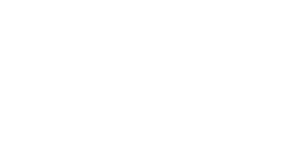

10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


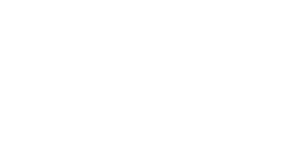

10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


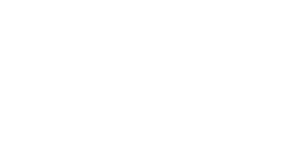

10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count
10-24-2022 11:03:21 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


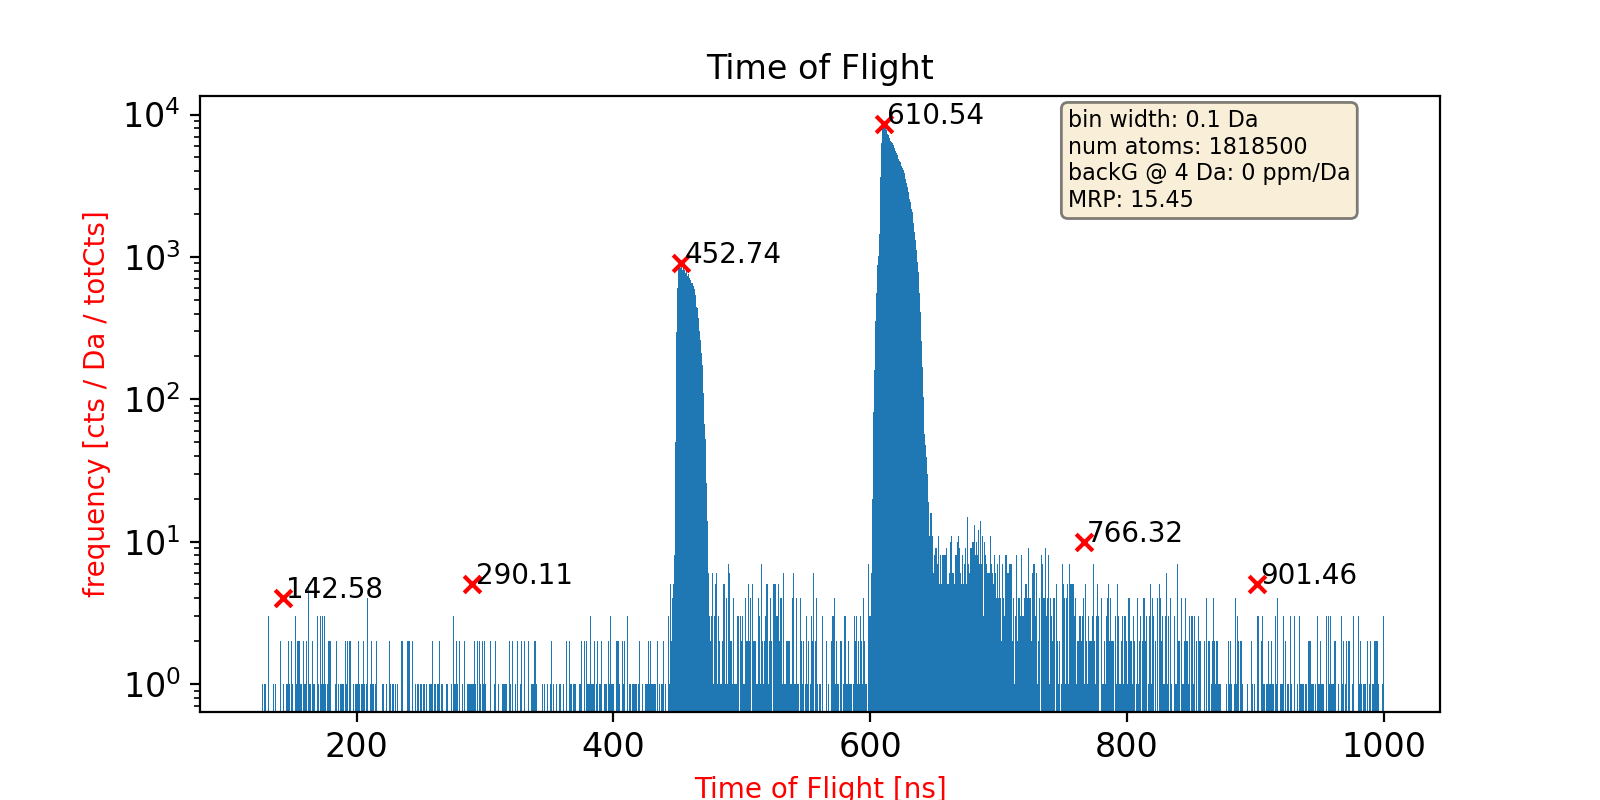

10-24-2022 11:03:26 | INFO | Selected Mode = count
10-24-2022 11:03:26 | INFO | Selected Mode = count
10-24-2022 11:03:26 | INFO | Selected Mode = count
10-24-2022 11:03:26 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


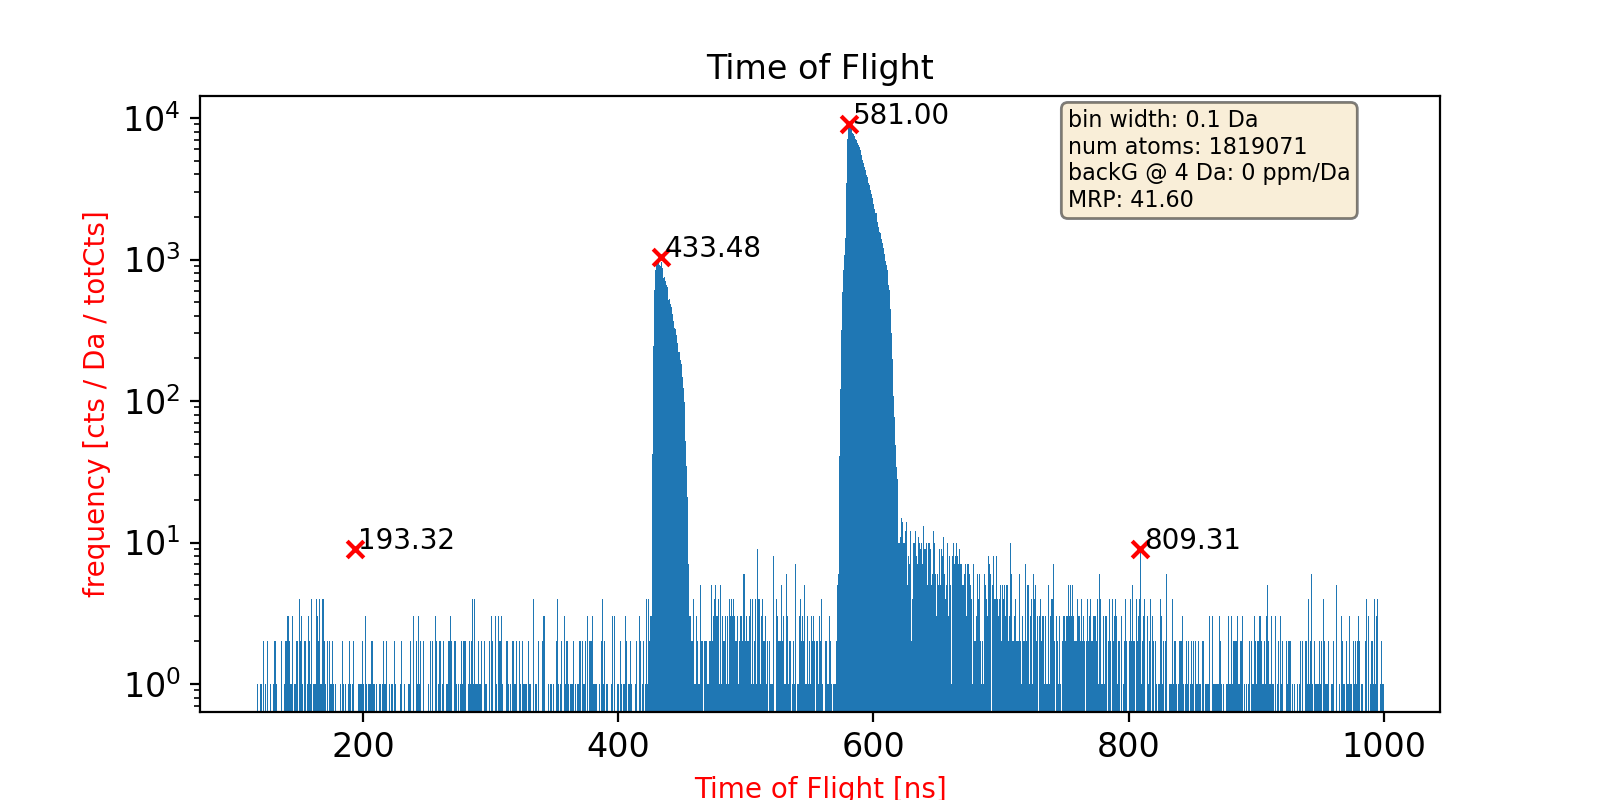

10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


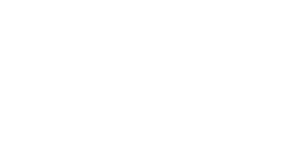

10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


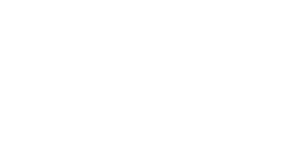

10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


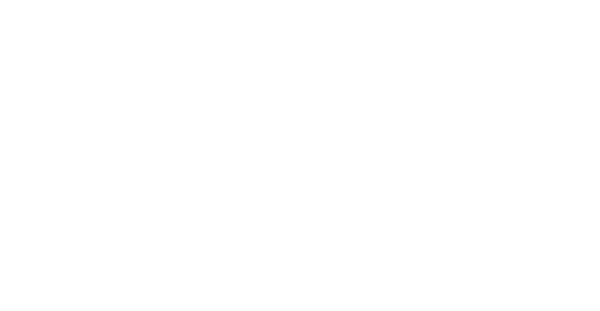

10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count
10-24-2022 11:03:37 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


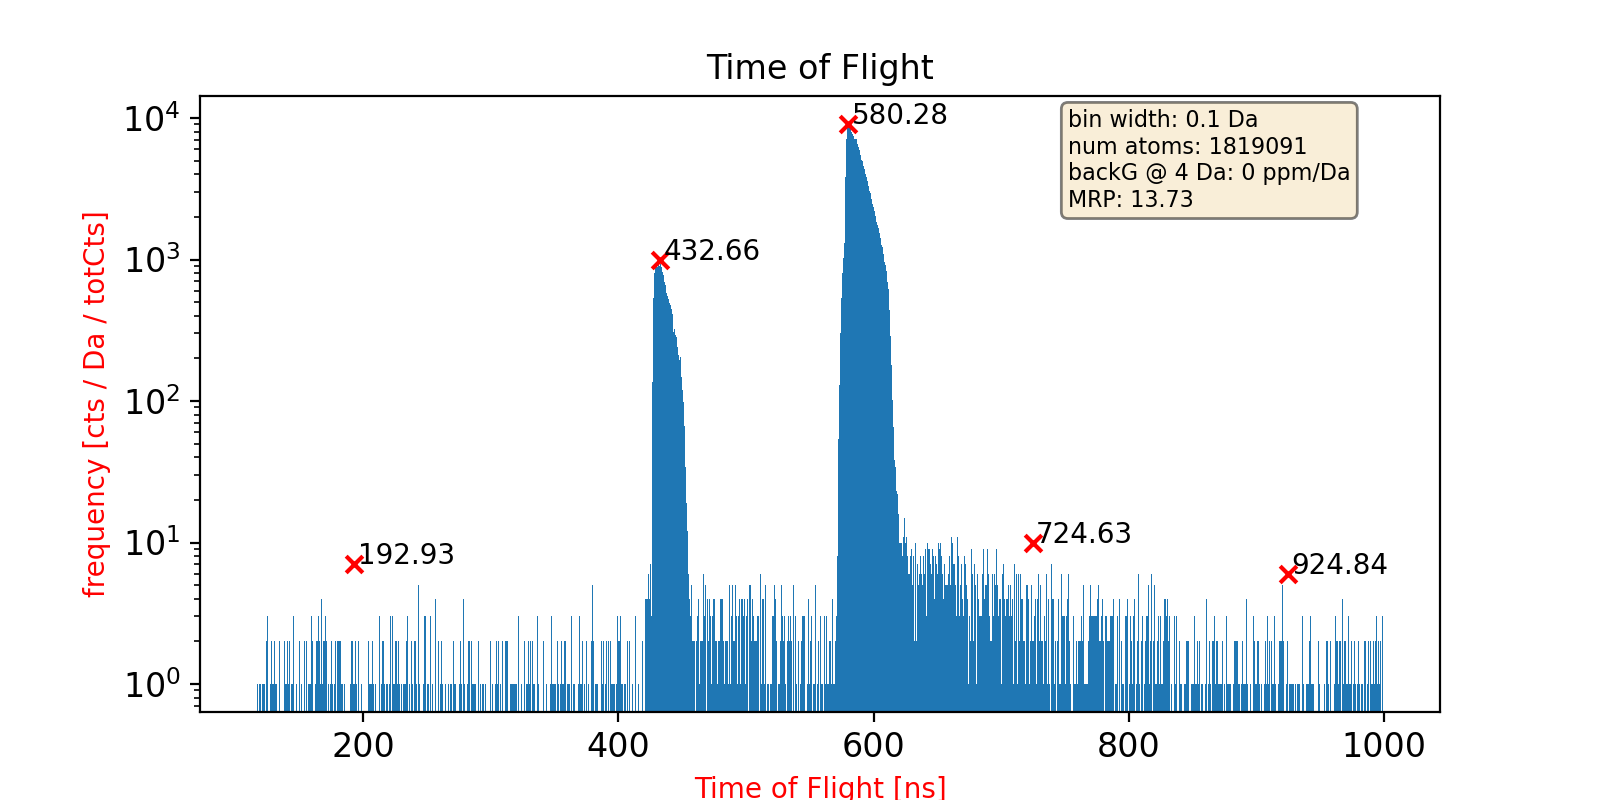

10-24-2022 11:03:42 | INFO | Selected Mode = count
10-24-2022 11:03:42 | INFO | Selected Mode = count
10-24-2022 11:03:42 | INFO | Selected Mode = count
10-24-2022 11:03:42 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


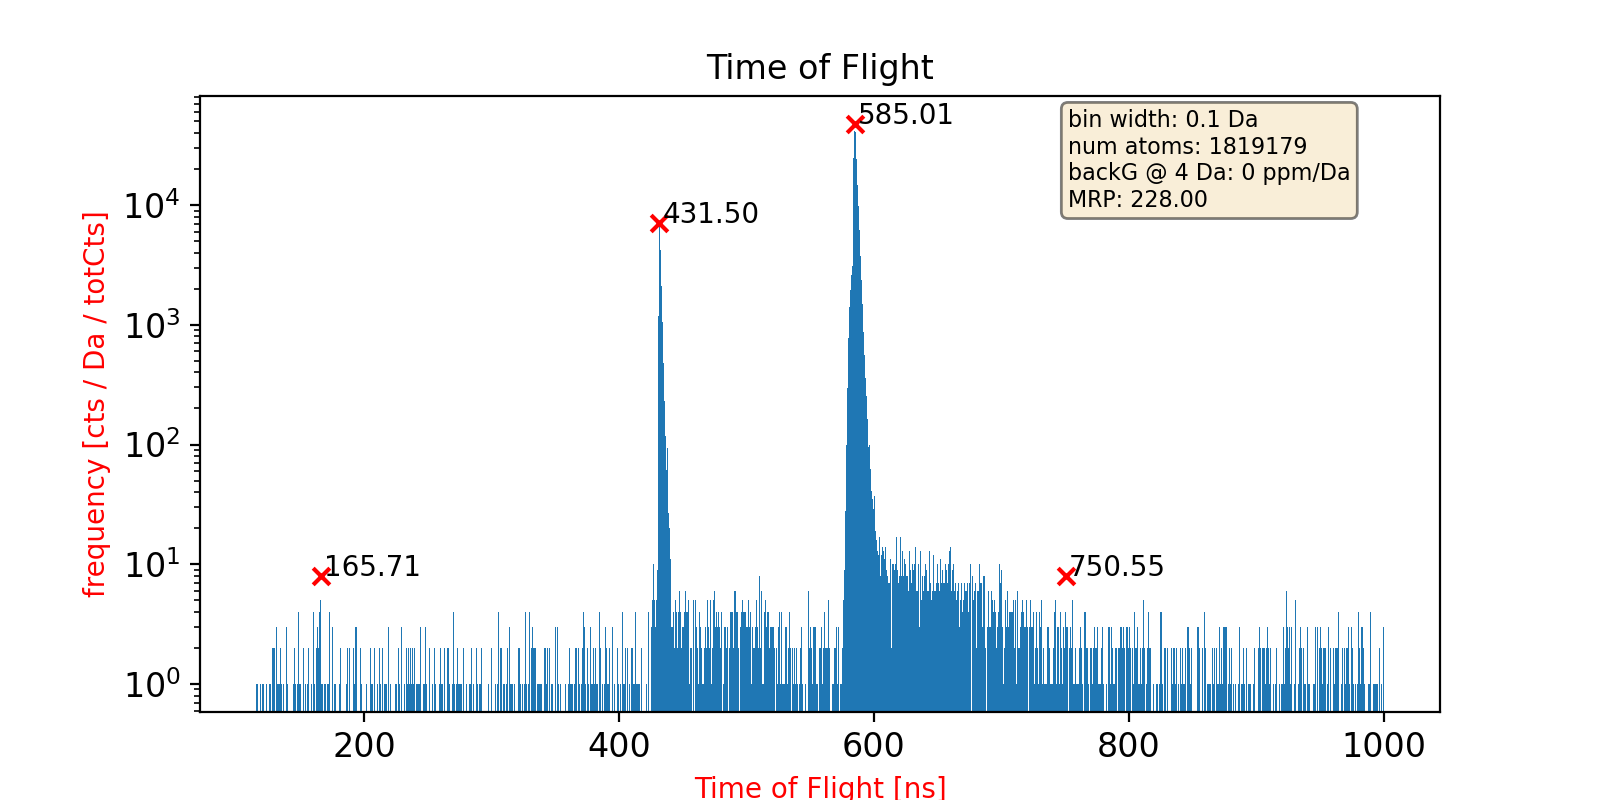

mrp_previous: [41.60209388] - mrp_v: [42.08093054] - mrp_bowl: [227.99512549]
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


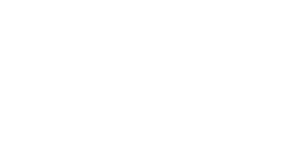

10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


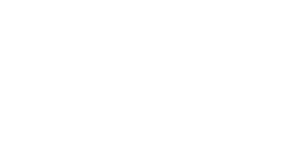

10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


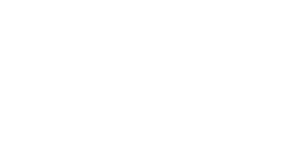

10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count
10-24-2022 11:03:53 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


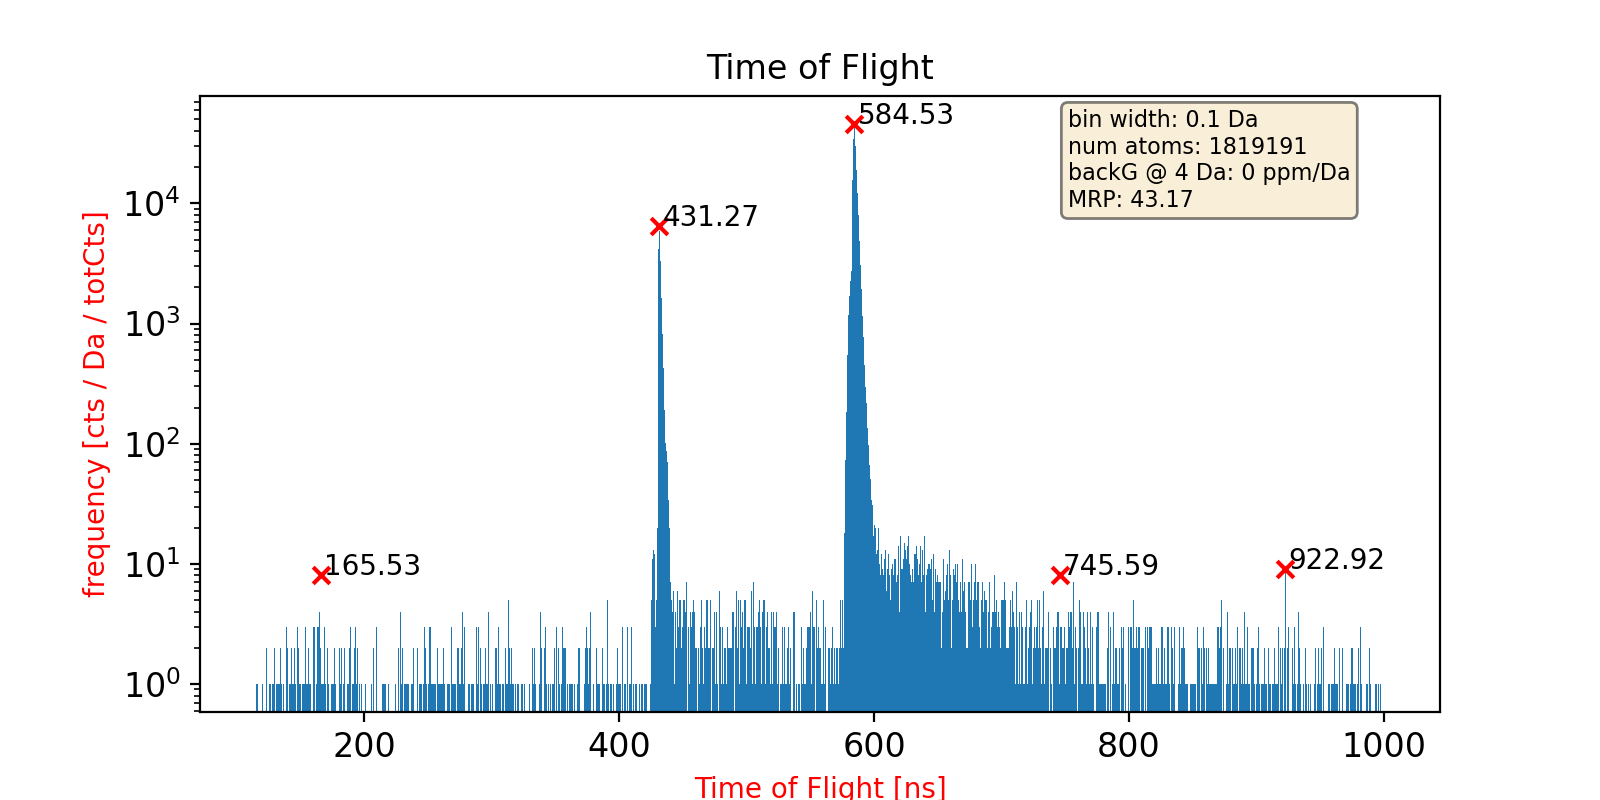

10-24-2022 11:03:59 | INFO | Selected Mode = count
10-24-2022 11:03:59 | INFO | Selected Mode = count
10-24-2022 11:03:59 | INFO | Selected Mode = count
10-24-2022 11:03:59 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


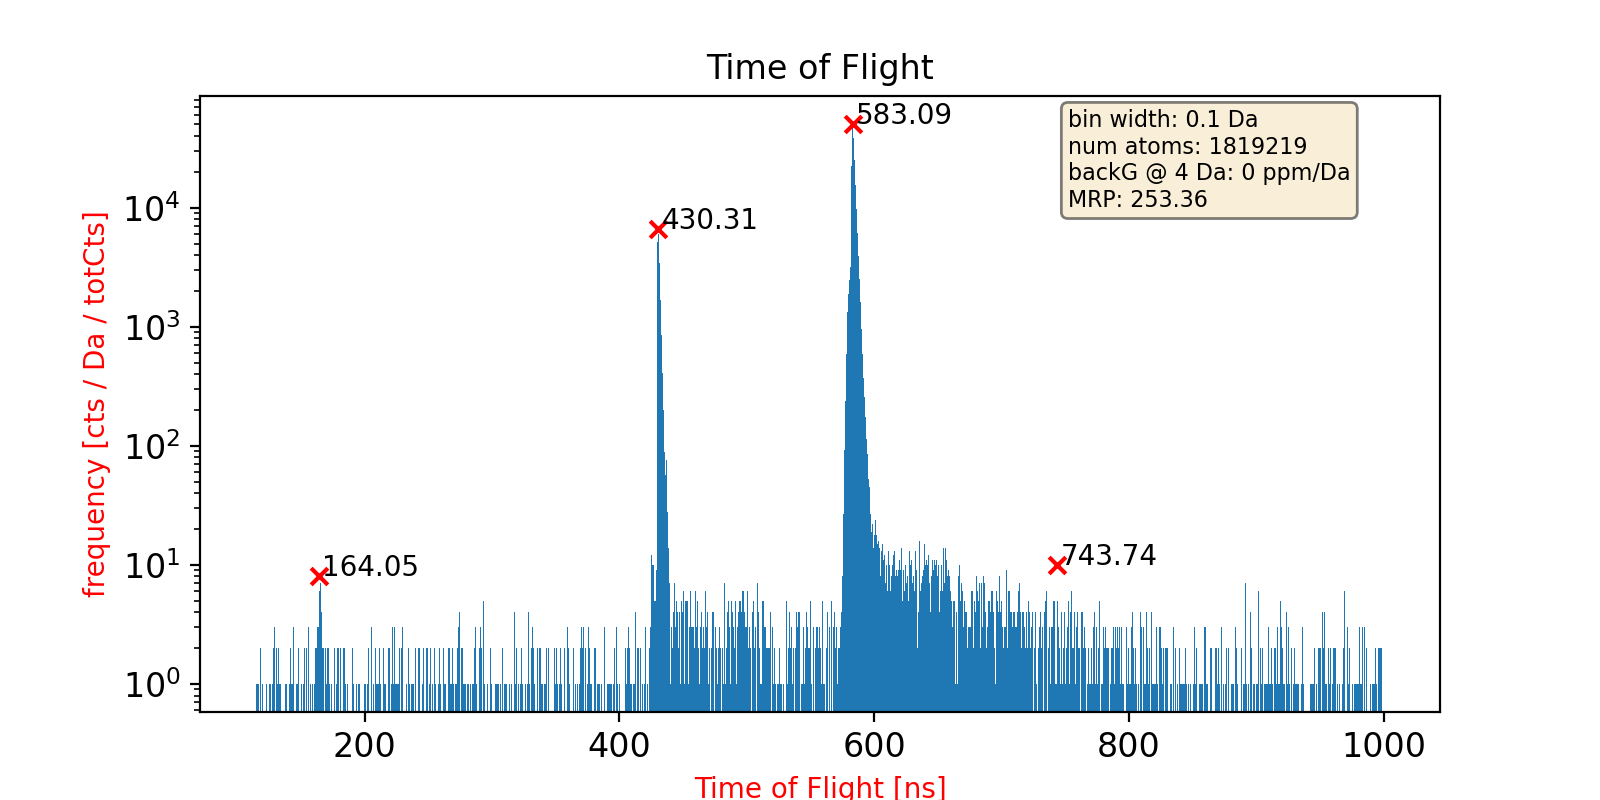

mrp_previous: [227.99512549] - mrp_v: [213.08284223] - mrp_bowl: [253.35741211]
10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


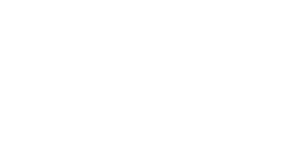

10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count
10-24-2022 11:04:08 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


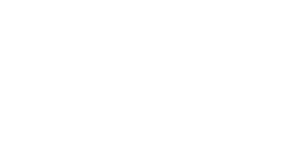

10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


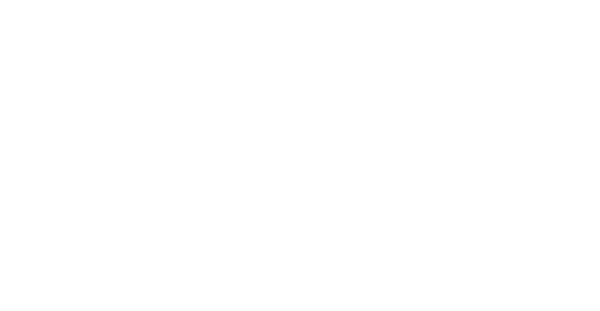

10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count
10-24-2022 11:04:09 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


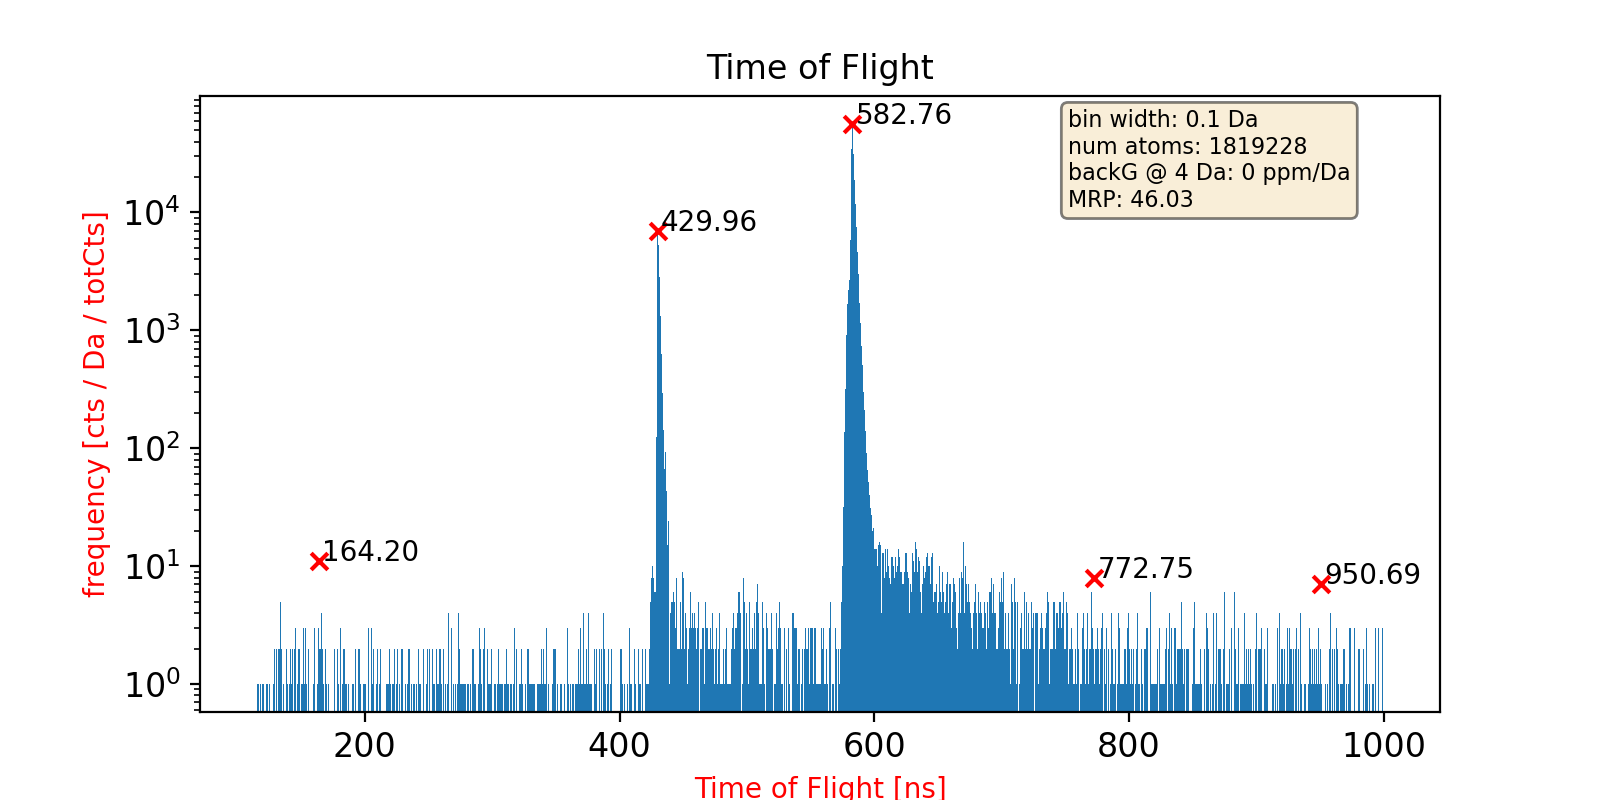

10-24-2022 11:04:15 | INFO | Selected Mode = count
10-24-2022 11:04:15 | INFO | Selected Mode = count
10-24-2022 11:04:15 | INFO | Selected Mode = count
10-24-2022 11:04:15 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


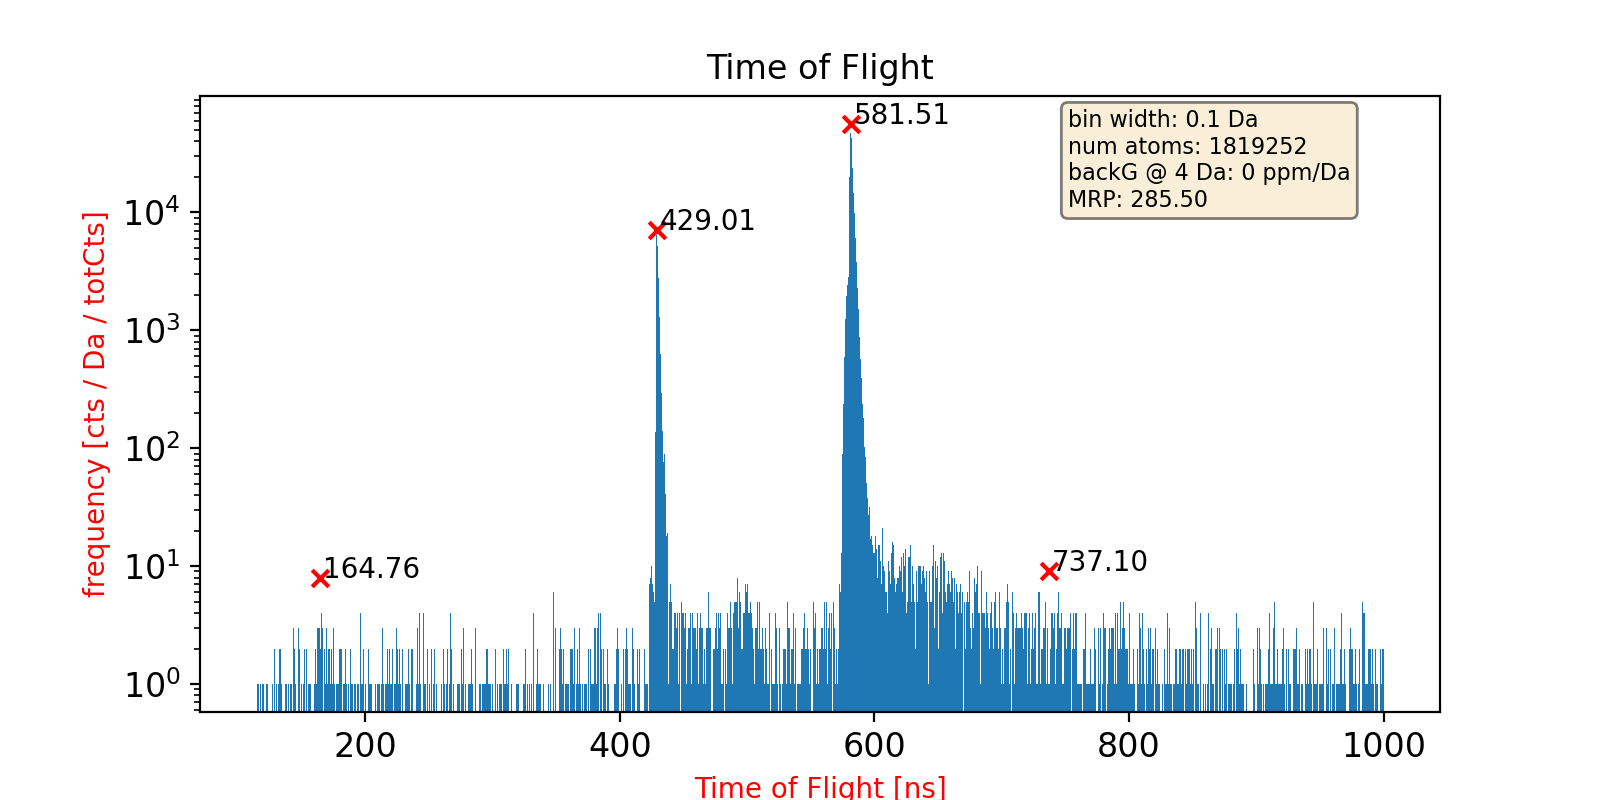

mrp_previous: [253.35741211] - mrp_v: [286.20668048] - mrp_bowl: [285.49713728]
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


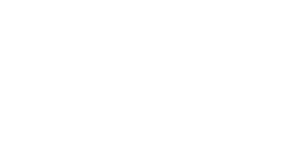

10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


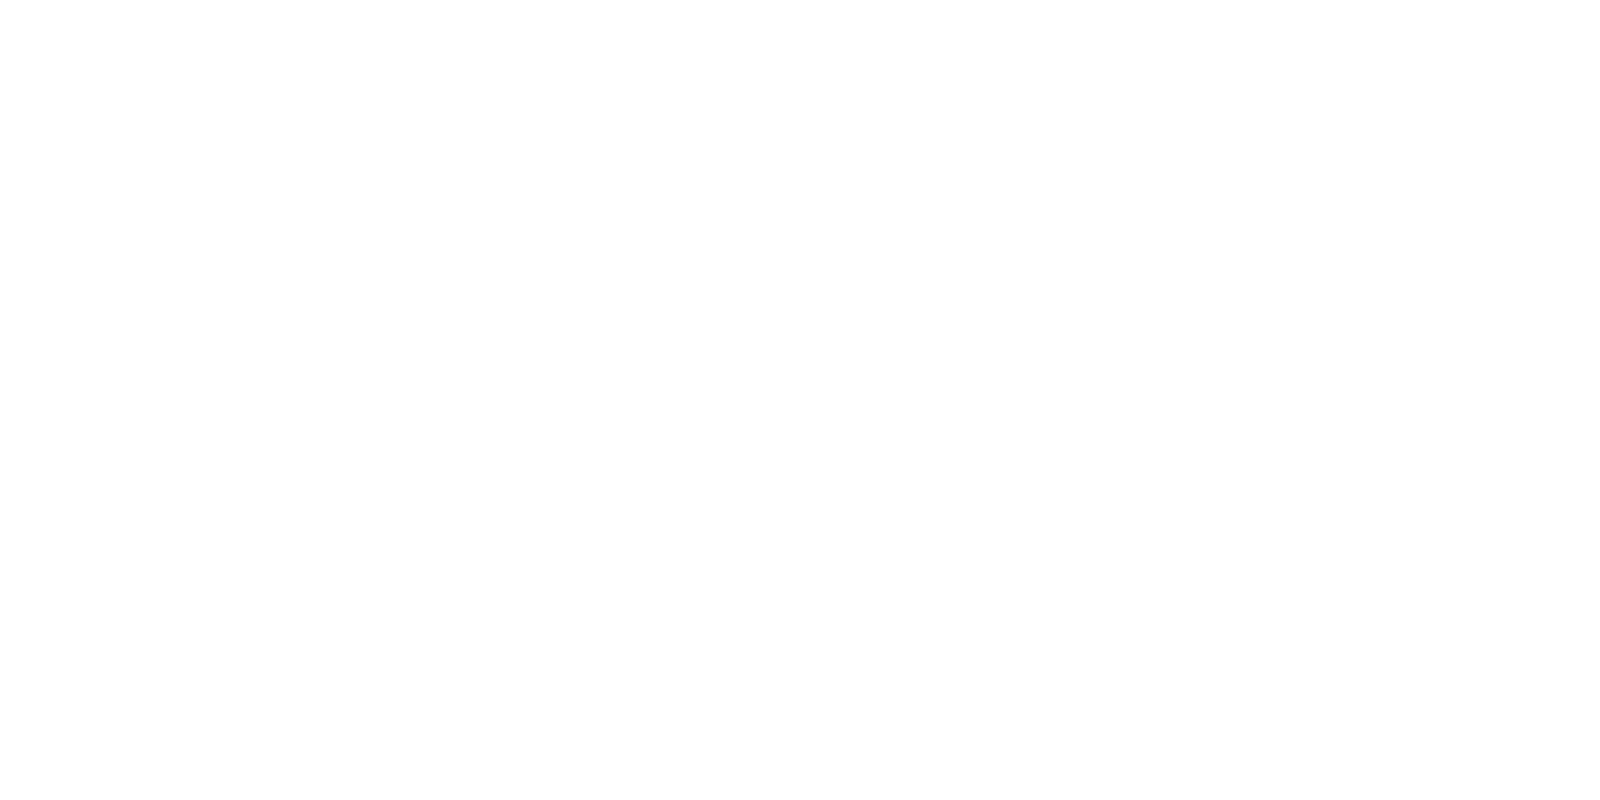

10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


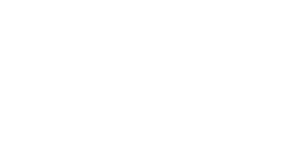

10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count
10-24-2022 11:04:27 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


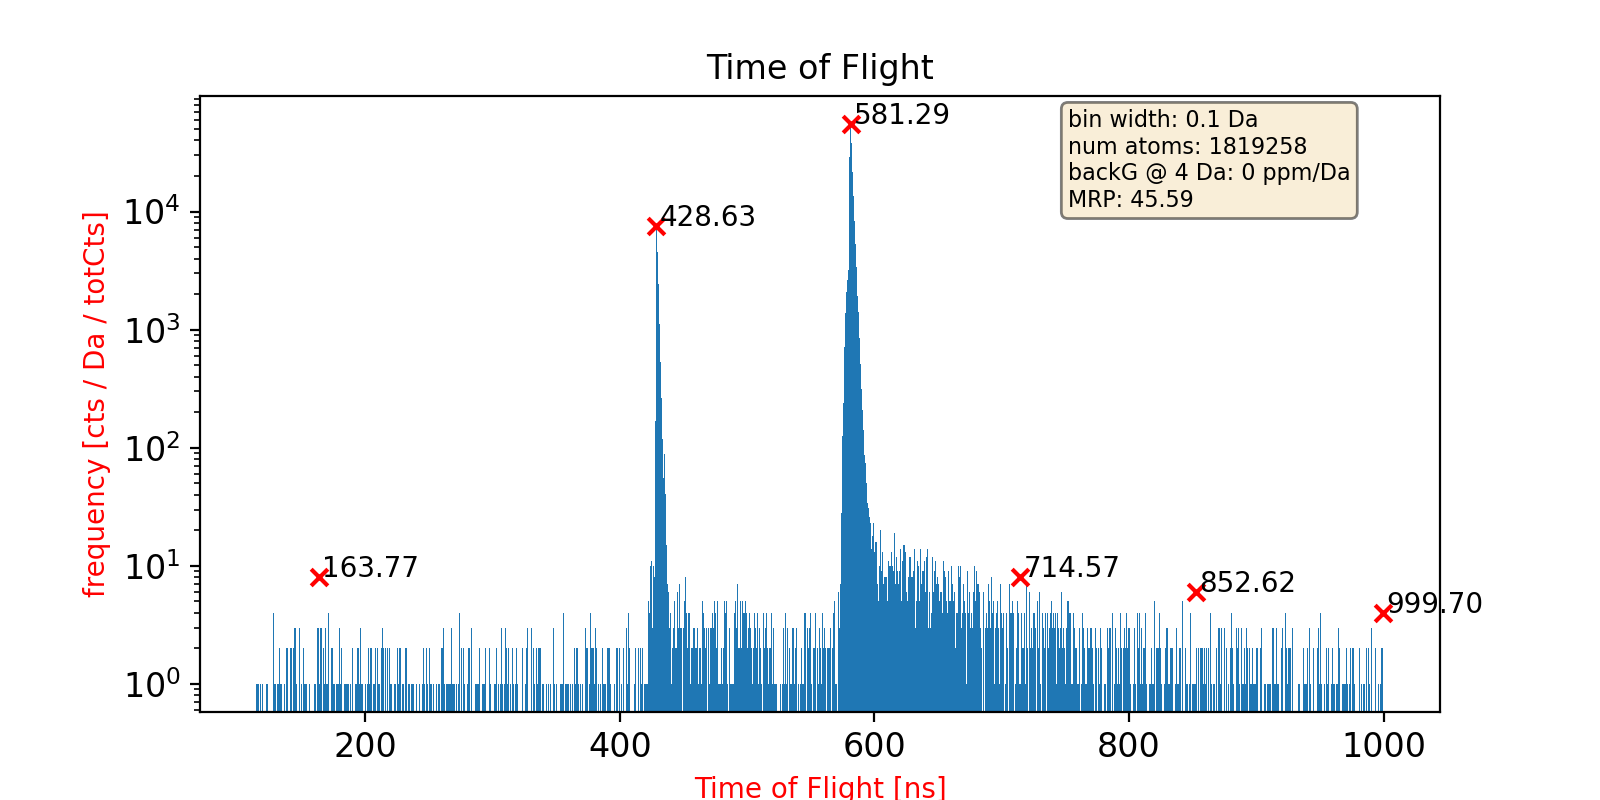

10-24-2022 11:04:31 | INFO | Selected Mode = count
10-24-2022 11:04:31 | INFO | Selected Mode = count
10-24-2022 11:04:31 | INFO | Selected Mode = count
10-24-2022 11:04:31 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


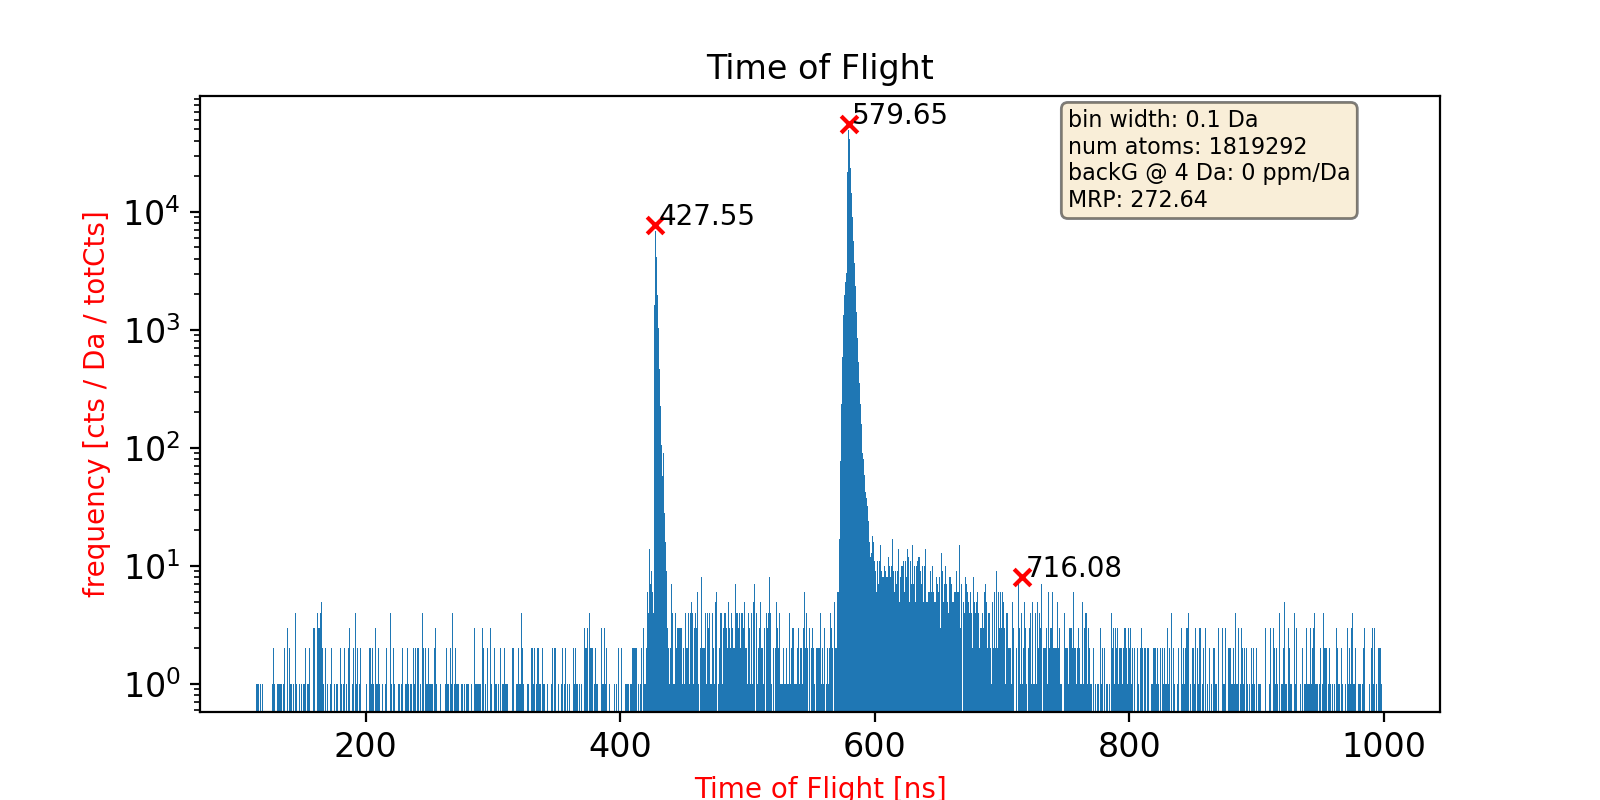

mrp_previous: [285.49713728] - mrp_v: [285.41153064] - mrp_bowl: [272.64027392]


In [17]:
i = 0
detector_squre = 2
dld_t_calib = np.copy(dld_t)
while True:
    index_fig = i
    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1,  distance=1500, percent=50, prominence=8, plot=plot_fig, label='tof', fig_name=figname+'_%s' %i)
    mrp_tof = (max_hist_tof / (left_right_peaks_tof[1] - left_right_peaks_tof[0]))
    max_hist_tof, left_right_peaks_tof, peaks_sides_tof, max_paek_edges_tof, index_max_tof = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1,  distance=1500, percent=1, prominence=8, plot=plot_fig, label='tof')
    peaks_selected = user_selected_peak(peaks_sides_tof, idx_peak)
    if i==0:
        mask_temporal = np.logical_and((peaks_selected[1] - 5 < dld_t_calib), (dld_t_calib < peaks_selected[2] - 10))
    else:
        mask_temporal = np.logical_and((peaks_selected[1] - 5 < dld_t_calib), (dld_t_calib < peaks_selected[2]))
    dld_t_calib_v = dld_t_calib[mask_temporal]
    dld_x_peak_v = dld_x[mask_temporal]
    dld_y_peak_v = dld_y[mask_temporal]
    dld_highVoltage_peak_v = dld_highVoltage[mask_temporal]
    dld_pulseVoltage_peak_v = dld_pulseVoltage[mask_temporal]

    mask_spacial = np.logical_and((np.abs(dld_x_peak_v) < detector_squre), (np.abs(dld_y_peak_v) < detector_squre))

    dld_t_calib_v = dld_t_calib_v[mask_spacial]
    dld_x_peak_v = dld_x_peak_v[mask_spacial]
    dld_y_peak_v = dld_y_peak_v[mask_spacial]
    dld_highVoltage_peak_v = dld_highVoltage_peak_v[mask_spacial]
    dld_pulseVoltage_peak_v = dld_pulseVoltage_peak_v[mask_spacial]

    fitresult = tof_calibration.voltage_coorection(dld_highVoltage_peak_v, dld_t_calib_v, index_fig, figname, plot=plot_fig, save=save_fig, num_sample=number_sample)

    f_v = tof_calibration.voltage_corr(dld_highVoltage, *fitresult)


    dld_t_calib = dld_t_calib * f_v
    

    max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=4, percent=50, plot=False, label='tof', fig_name='V_'+figname+'_%s' %i)
    mrp_v = (max_hist_tof_v / (left_right_peaks_tof_v[1] - left_right_peaks_tof_v[0]))
    max_hist_tof_v, left_right_peaks_tof_v, peaks_sides_tof_v, max_paek_edges_tof_v, index_max_tof_v = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=4, percent=1, plot=True, label='tof')

    peaks_selected_v = user_selected_peak(peaks_sides_tof_v, idx_peak)
    
    mask_temporal_bowl = np.logical_and((peaks_selected_v[1] - 10 < dld_t_calib), (dld_t_calib < peaks_selected_v[2] + 40))

    dld_t_calib_bowl = dld_t_calib[mask_temporal_bowl]
    dld_x_peak_bowl = dld_x[mask_temporal_bowl]
    dld_y_peak_bowl = dld_y[mask_temporal_bowl]
    dld_highVoltage_peak_bowl = dld_highVoltage[mask_temporal_bowl]
    dld_pulseVoltage_peak_bowl = dld_pulseVoltage[mask_temporal_bowl]
    
    mask_bowl = np.logical_and((dld_highVoltage_peak_bowl), (dld_highVoltage_peak_bowl))
    
    dld_highVoltage_bowl = dld_highVoltage_peak_bowl[mask_bowl]
    dld_pulseVoltage_bowl = dld_pulseVoltage_peak_bowl[mask_bowl]
    dld_x_bowl = dld_x_peak_bowl[mask_bowl]
    dld_y_bowl = dld_y_peak_bowl[mask_bowl] 
    dld_t_calib_bowl = dld_t_calib_bowl[mask_bowl]
    

    
    #target_bowl = scaler1.fit_transform(target_bowl.reshape(-1, 1)).reshape((-1,)) 
    parameters = tof_calibration.bowl_correction(dld_x_bowl, dld_y_bowl, dld_t_calib_bowl, peaks_selected_v[0], index_fig, figname, plot=plot_fig, save=save_fig)

    scaler2 = MinMaxScaler(feature_range=(-1, 1))
    dld_x_norm = scaler2.fit_transform(dld_x.reshape(-1, 1)).reshape((-1,)) 
    dld_y_norm = scaler2.fit_transform(dld_y.reshape(-1, 1)).reshape((-1,)) 

    f_bowl = tof_calibration.bowl_corr_fit([dld_x_norm,dld_y_norm], *parameters)
    
    dld_t_calib = dld_t_calib * f_bowl
    
    max_hist_tof_bowl, left_right_peaks_tof_bowl, peaks_sides_tof_bowl, max_paek_edges_tof_bowl, index_max_tof_bowl = tools.massSpecPlot(dld_t_calib[dld_t_calib < 1000], 0.1, distance=1500, prominence=8, percent=50, plot=True, label='tof', fig_name='bowl_'+figname+'_%s' %i)
    mrp_bowl = (max_hist_tof_bowl / (left_right_peaks_tof_bowl[1] - left_right_peaks_tof_bowl[0]))


    if i == 0:
        mrp_final = mrp_bowl
        dld_t_calib_final = np.copy(dld_t_calib)

    else:
        if mrp_final > mrp_bowl:
            print(f"mrp_previous: {mrp_final} - mrp_v: {mrp_v} - mrp_bowl: {mrp_bowl}")
            break
        else:
            print(f"mrp_previous: {mrp_final} - mrp_v: {mrp_v} - mrp_bowl: {mrp_bowl}")
            mrp_final = mrp_bowl
            dld_t_calib_final = np.copy(dld_t_calib)
    i = i + 1


10-24-2022 11:05:20 | INFO | Selected Mode = count
10-24-2022 11:05:20 | INFO | Selected Mode = count
10-24-2022 11:05:20 | INFO | Selected Mode = count
10-24-2022 11:05:20 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


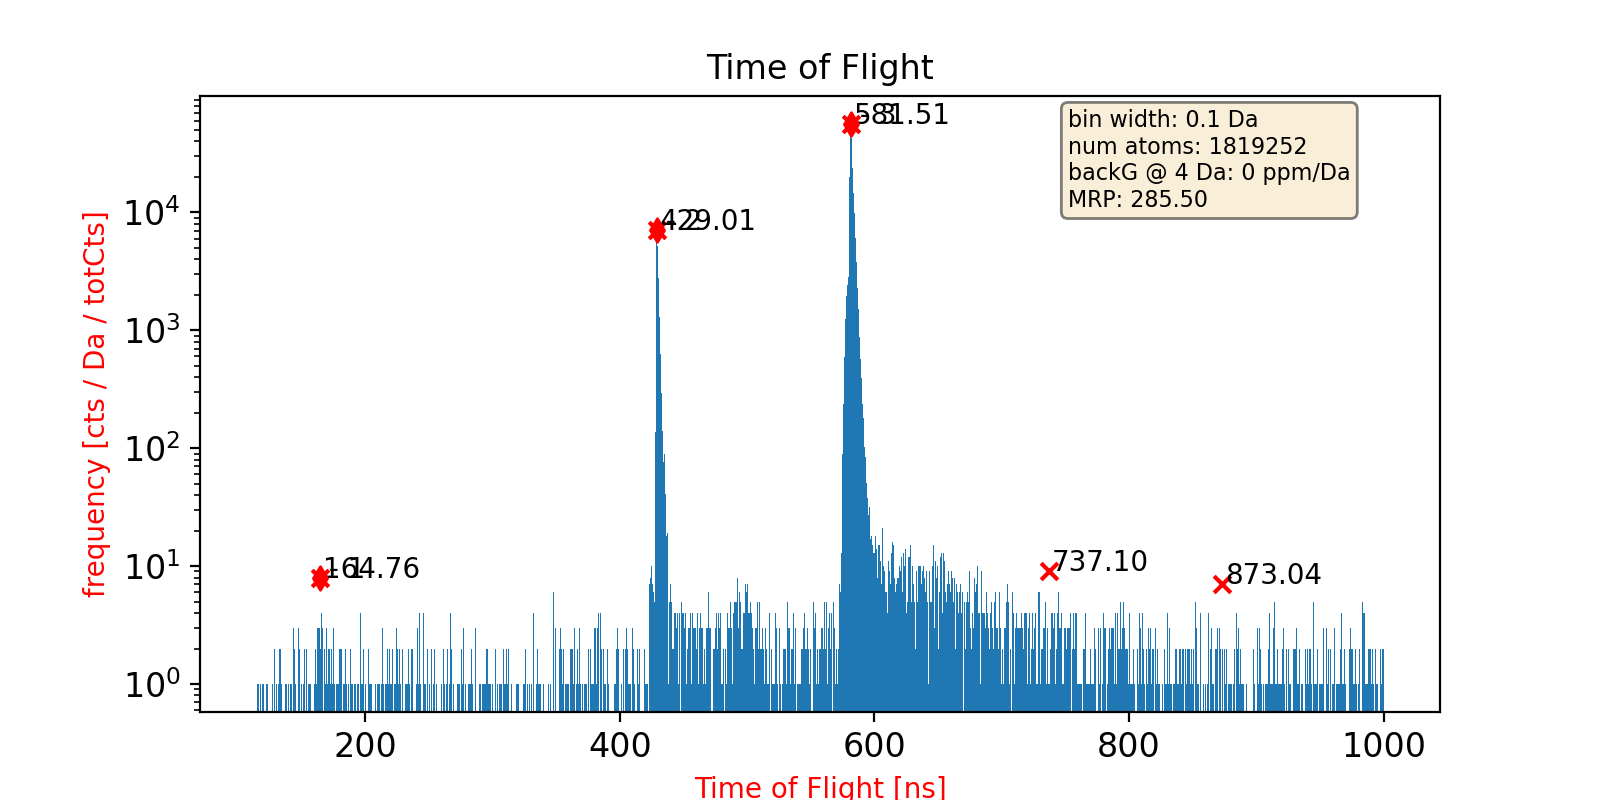

In [18]:
variables.peaks_idx = []
max_hist_tof_f, left_right_peaks_tof_f, peaks_sides_tof_f, max_paek_edges_tof_f, index_max_tof_f = tools.massSpecPlot(dld_t_calib_final[dld_t_calib_final < 1000], 0.1, distance=1500, prominence=4, percent=50, plot=True, label='tof', fig_name='bowl_'+figname)

In [19]:
isotopeTableFile = '../../../files/isotopeTable.h5'
dataframe = data_tools.read_hdf5_through_pandas(isotopeTableFile)
elementsList = dataframe['element']
elementIsotopeList = dataframe['isotope']
elementMassList =  dataframe['weight']
abundanceList = dataframe['abundance']

elements = list(zip(elementsList, elementIsotopeList, elementMassList, abundanceList))
dropdownList = []
for element in elements:
    tupleElement = ("{} ({}) ({:.2f})".format(element[0], element[1], element[3]), element[2],)
    dropdownList.append(tupleElement)

chargeList = [(1,1,),(2,2,),(3,3,),(4,4,)]
dropdown = wd.dropdownWidget(dropdownList,"Elements")
dropdown.observe(wd.on_change)


chargeDropdown = wd.dropdownWidget(chargeList,"Charge")
chargeDropdown.observe(wd.on_change_charge)

wd.compute_element_isotope_values_according_to_selected_charge()

buttonAdd = wd.buttonWidget("ADD")
buttonDelete = wd.buttonWidget("DELETE")
buttonReset = wd.buttonWidget("RESET")

display(dropdown, chargeDropdown, buttonAdd, buttonDelete, buttonReset)

listMaterial = buttonAdd.on_click(wd.onClickAdd)
buttonDelete.on_click(wd.onClickDelete)
buttonReset.on_click(wd.onClickReset)

Dropdown(description='Elements', options=(('H (1) (99.98)', 1.01), ('H (2) (0.01)', 2.01), ('He (3) (0.00)', 3…

Dropdown(description='Charge', options=((1, 1), (2, 2), (3, 3), (4, 4)), value=1)

Button(description='ADD', icon='check', style=ButtonStyle(), tooltip='ADD')

Button(description='DELETE', icon='check', style=ButtonStyle(), tooltip='DELETE')

Button(description='RESET', icon='check', style=ButtonStyle(), tooltip='RESET')

In [20]:
peaks_chos = []
for i in range(len(variables.peaks_idx)):
    peaks_chos.append(peaks_sides_tof_f[variables.peaks_idx[i],0])
peaks_chos = np.array(peaks_chos)
listMaterial = np.array(variables.listMaterial)
print('highest peak in the tof histogram:', peaks_chos)
print('highest peak in the ideal mc histogram:', listMaterial)

highest peak in the tof histogram: [164.7551537  429.01034201 581.50613097]
highest peak in the ideal mc histogram: [ 1.01 13.49 26.98]


In [21]:
def parametric(t, t0, c, d):

    return c * ((t - t0)**2) + d

def parametric_calib(t, mc_ideal):
    
    fitresult, _ = curve_fit(parametric, t, mc_ideal)
    return fitresult

fitresult = parametric_calib(peaks_chos,  variables.listMaterial)


mc_p_1 = parametric(dld_t_calib_final, *fitresult)

C:\ProgramData\Anaconda3\envs\oxcart4\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


10-24-2022 11:06:42 | INFO | Selected Mode = count
10-24-2022 11:06:42 | INFO | Selected Mode = count
10-24-2022 11:06:42 | INFO | Selected Mode = count
10-24-2022 11:06:42 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


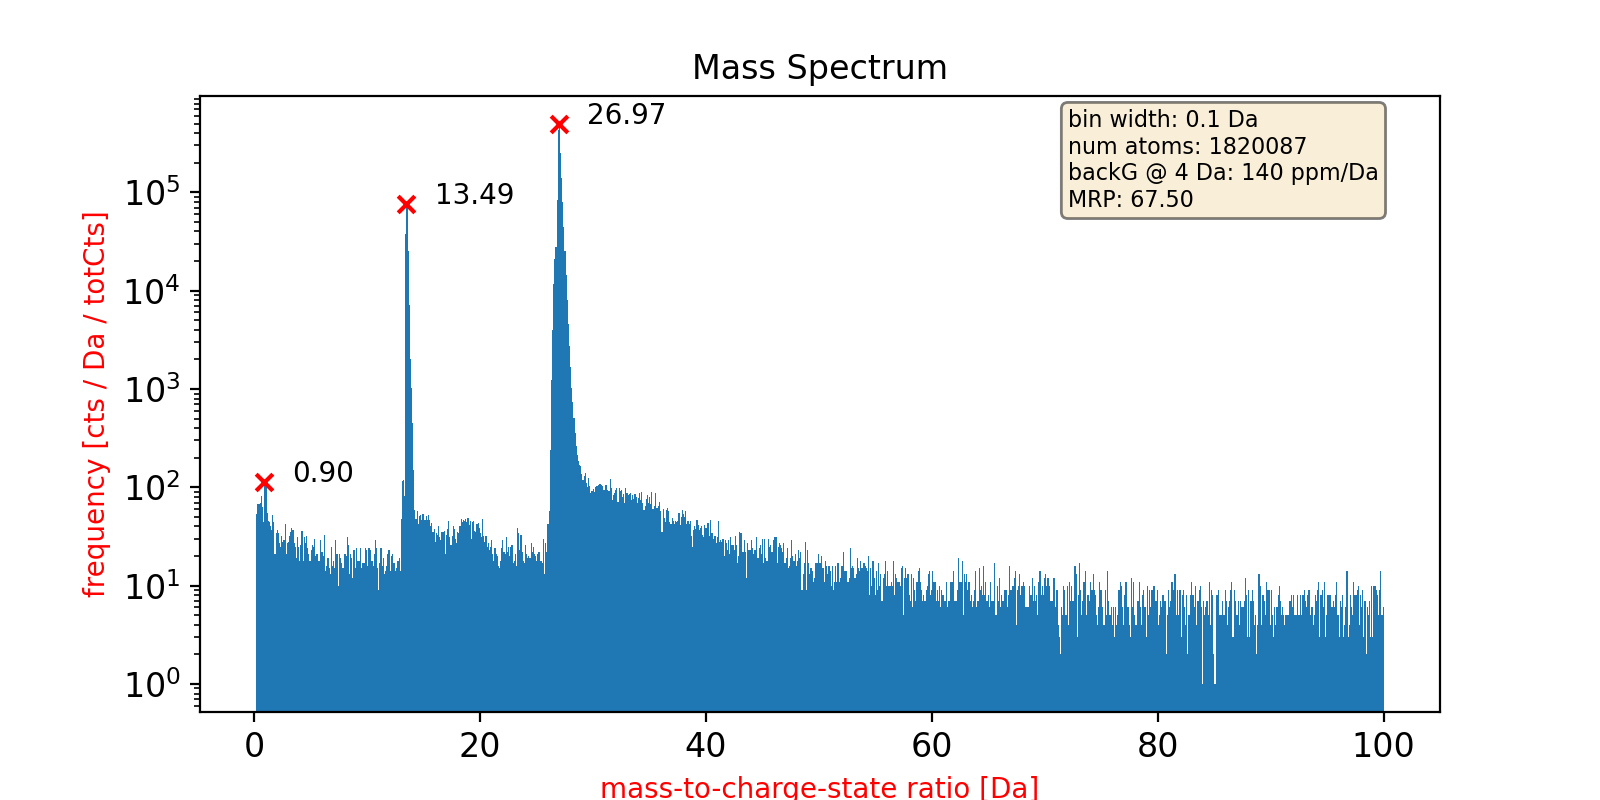

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [67.50287879]
Peaks  0 is: 0.90 peak window sides are: 0.80 - 1.10
Peaks  1 is: 13.49 peak window sides are: 13.39 - 13.59
Peaks  2 is: 26.97 peak window sides are: 26.77 - 27.17


In [22]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_1[mc_p_1 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_1'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [23]:
delta_t = interpolate.interp1d(peaks_chos, variables.listMaterial, kind='linear', fill_value="extrapolate")
mc_p_2 = delta_t(dld_t_calib_final)  


10-24-2022 11:07:07 | INFO | Selected Mode = count
10-24-2022 11:07:07 | INFO | Selected Mode = count
10-24-2022 11:07:07 | INFO | Selected Mode = count
10-24-2022 11:07:07 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


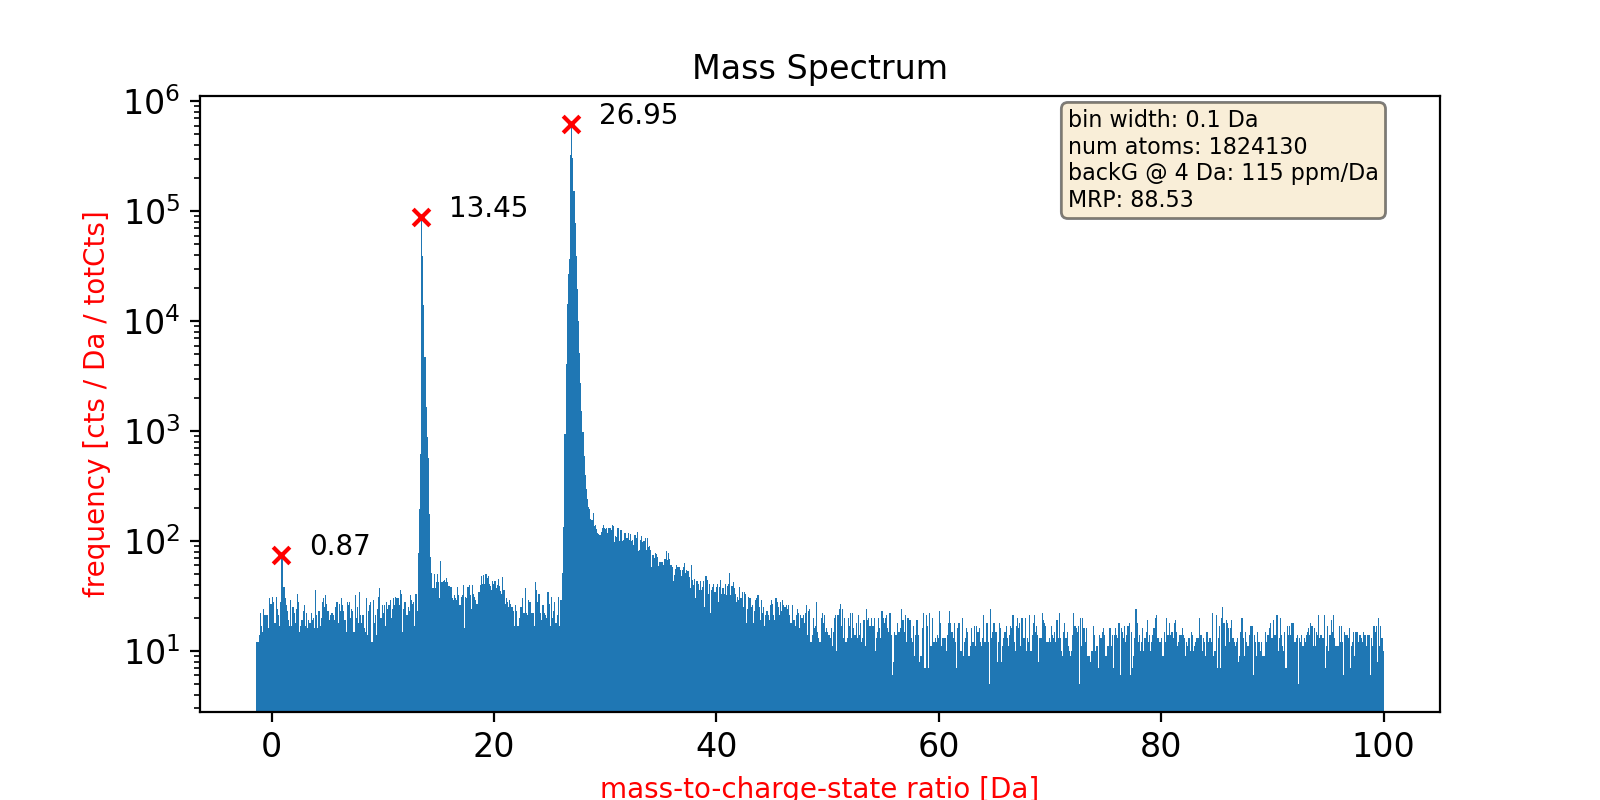

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [88.52749516]
Peaks  0 is: 0.87 peak window sides are: 0.77 - 1.18
Peaks  1 is: 13.45 peak window sides are: 13.35 - 13.55
Peaks  2 is: 26.95 peak window sides are: 26.74 - 27.05


In [24]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc_p_2[mc_p_2 < 100], 0.1, prominence=50, distance=100, text_loc='right', percent=50, plot=True, fig_name='mc2_p_2'+figname)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides_p)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [25]:
data['mc (Da)'] = mc_p_2

In [26]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp,mc (Da)
0,5216.226562,5216.226562,1572.0,633.384306,-0.031837,0.859592,0.0,1.0,27.713360
1,5216.226562,5216.226562,1791.0,628.981470,-0.350204,-18.720000,219.0,1.0,27.003132
2,5216.226562,5216.226562,1992.0,635.510286,-11.906939,2.610612,201.0,1.0,27.493455
3,5216.226562,5216.226562,2429.0,624.222018,7.195102,-0.827755,437.0,1.0,26.965459
4,5216.226562,5216.226562,3220.0,629.276364,14.644898,7.449796,791.0,1.0,27.027015
...,...,...,...,...,...,...,...,...,...
1858635,5711.025879,5711.025879,3626.0,601.419168,-4.998367,-1.846531,152.0,1.0,26.985305
1858636,5711.025879,5711.025879,3641.0,602.674182,-0.827755,-14.867755,15.0,1.0,26.971058
1858637,5711.025879,5711.025879,4538.0,600.644214,-6.271837,3.565714,897.0,1.0,26.801420
1858638,5711.025879,5711.025879,5881.0,459.993492,34.097143,5.380408,1343.0,1.0,13.680422


In [27]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')